# ABIS-RUU – Baseline GPU Behaviour Experiment

This notebook implements:

• CNN training on CIFAR-10  
• Real-time GPU telemetry monitoring using NVML  
• Batch-size scaling experiment (128 vs 256)  
• GPU utilization and memory comparison  

Objective:
To analyze baseline GPU behaviour and observe how workload scaling impacts resource utilization.


## 1. Environment Setup



In [1]:
!nvidia-smi
!pip install nvidia-ml-py3


Wed Feb 18 16:24:18 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Library Imports & Device Configuration

Importing PyTorch, TorchVision, and setting up CUDA device.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## 3. GPU Telemetry Initialization

Initializing NVIDIA Management Library (NVML) for real-time GPU monitoring.


In [3]:
from pynvml import *
import time
import csv

nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)


## 4. Dataset Preparation

Loading CIFAR-10 dataset and applying preprocessing transformations.


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)


100%|██████████| 170M/170M [00:04<00:00, 41.2MB/s]


## 5. CNN Model Architecture

Defining a simple convolutional neural network for image classification.


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)


## 6. Training Configuration

Defining loss function and optimization strategy.


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## 7. Experimental Framework

Running controlled batch-size experiments while logging GPU utilization and memory usage.


In [10]:
def run_experiment(batch_size):

    print(f"\nStarting experiment with batch size {batch_size}")

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True)

    log_filename = f"gpu_log_{batch_size}.csv"

    with open(log_filename, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Time", "GPU_Util", "Memory_MB"])

        for epoch in range(1):
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # GPU Monitoring
                util = nvmlDeviceGetUtilizationRates(handle).gpu
                mem = nvmlDeviceGetMemoryInfo(handle).used / 1024**2

                writer.writerow([time.time(), util, mem])

                if i % 100 == 99:
                    print(f"[BatchSize {batch_size}] Batch {i+1}, GPU: {util}%, Mem: {mem:.0f}MB")

    print(f"Finished experiment for batch size {batch_size}")


## 8. Comparative Analysis

Loading telemetry logs and comparing GPU utilization and memory usage across configurations.


In [11]:


df_128 = pd.read_csv("gpu_log_128.csv")
df_256 = pd.read_csv("gpu_log_256.csv")

print("128 samples:", len(df_128))
print("256 samples:", len(df_256))

print("Average GPU Utilization:")
print("Batch 128:", df_128["GPU_Util"].mean())
print("Batch 256:", df_256["GPU_Util"].mean())

print("\nAverage GPU Memory Usage (MB):")
print("Batch 128:", df_128["Memory_MB"].mean())
print("Batch 256:", df_256["Memory_MB"].mean())



128 samples: 391
256 samples: 196
Average GPU Utilization:
Batch 128: 17.843989769820972
Batch 256: 16.882653061224488

Average GPU Memory Usage (MB):
Batch 128: 666.1875
Batch 256: 840.1875


In [9]:
run_experiment(128)
run_experiment(256)



Starting experiment with batch size 128
[BatchSize 128] Batch 100, GPU: 19%, Mem: 666MB
[BatchSize 128] Batch 200, GPU: 18%, Mem: 666MB
[BatchSize 128] Batch 300, GPU: 19%, Mem: 666MB
Finished experiment for batch size 128

Starting experiment with batch size 256
[BatchSize 256] Batch 100, GPU: 12%, Mem: 840MB
Finished experiment for batch size 256


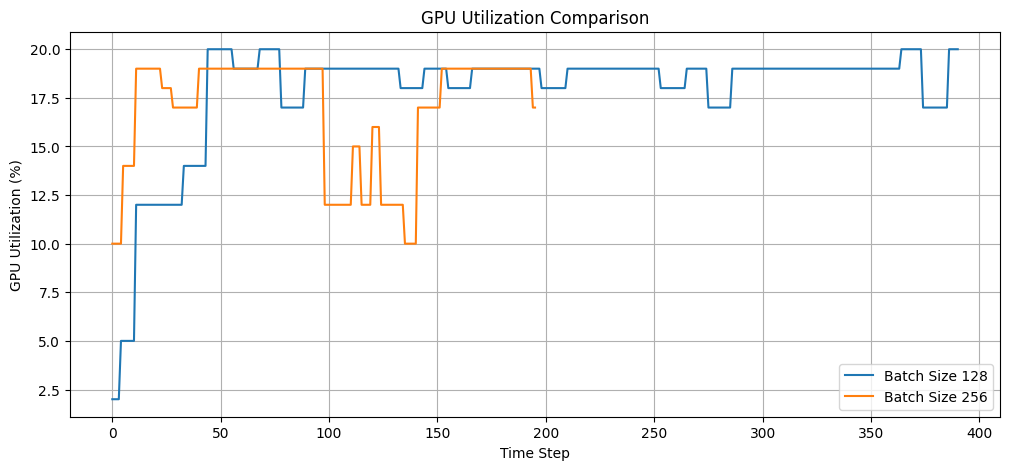

In [12]:
plt.figure(figsize=(12,5))

plt.plot(df_128["GPU_Util"], label="Batch Size 128")
plt.plot(df_256["GPU_Util"], label="Batch Size 256")

plt.title("GPU Utilization Comparison")
plt.xlabel("Time Step")
plt.ylabel("GPU Utilization (%)")
plt.legend()
plt.grid(True)

plt.show()


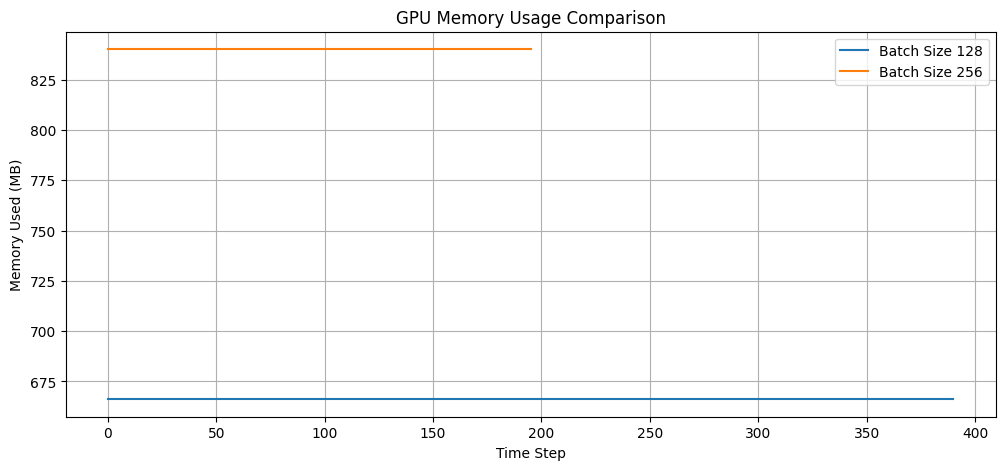

In [13]:
plt.figure(figsize=(12,5))

plt.plot(df_128["Memory_MB"], label="Batch Size 128")
plt.plot(df_256["Memory_MB"], label="Batch Size 256")

plt.title("GPU Memory Usage Comparison")
plt.xlabel("Time Step")
plt.ylabel("Memory Used (MB)")
plt.legend()
plt.grid(True)

plt.show()


## 9. Conclusion

Batch-size scaling increases GPU memory usage significantly, while GPU utilization shows modest improvement. These findings highlight baseline behavioral patterns and motivate adaptive optimization strategies.
